
# Example 2: Running 'denoised-PCA' using GSN signal covariance matrix



In [96]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import scipy.io as sio
import os
from os.path import join, exists, split
import sys
import glob
import urllib.request
import zipfile

# Add the GSN project directory to the system path
sys.path.append(f'{os.getcwd()}/../')

# Import GSN-related modules
from gsn.perform_gsn import perform_gsn

The goal of this notebook is to demonstrate how using GSN-derived signal covariance improves PCA for cross-participant consistency.

The core premise is that that signal, not noise, is expected to generalize across participants. If GSN successfully separates signal from noise in each participant, then principal components derived from a signal covariance should exhibit improved consistency across participants compared to principal components derived from a standard covariance based on trial-averaged data (a mix of signal and noise). 

We used data from eight participants from the [NSD dataset](https://www.nature.com/articles/s41593-021-00962-x) who viewed a common set of 515 images three times each.
Our region of interest (ROI) is FFA-1 (fusiform face area) in the right hemisphere. For each participant, we selected the 100 voxels with the highest mean BOLD response.

For each participant, we computed trial-averaged responses and then projected these responses onto:

**GSN PCA**: the first principal component of the signal covariance estimated by GSN (i.e., 'denoised-PCA').

**Standard PCA**: the first principal component of the covariance of trial-averaged data.

We compare cross-participant consistency by computing cosine similarity of these projections across all participant pairs (largely mirroring the analysis in Figure 7C in the paper).

# Download dataset

In [111]:
# get path to the directory to which GSN was installed
homedir = split(os.getcwd())[0]

# create directory for saving data
datadir = join(homedir,'examples','data')
os.makedirs(datadir,exist_ok=True)

# download example dataset from GSN OSF repository
zipfn = join(datadir, 'example_ffa_nsd_data.zip')
extract_dir = join(datadir, 'ffa_nsd_data')
dataurl = 'https://osf.io/download/n4bwp/?direct'  # Direct link

# Download if missing
if not exists(zipfn):
    print(f'Downloading dataset to: {zipfn}')
    urllib.request.urlretrieve(dataurl, zipfn)

# Extract if missing
if not exists(extract_dir):
    print(f'Extracting ZIP to: {extract_dir}')
    with zipfile.ZipFile(zipfn, 'r') as zip_ref:
        zip_ref.extractall(datadir)
else:
    print('Data already extracted.')

# Load .mat files
files = glob.glob(f'{extract_dir}/*.mat')

# Load a matrix of percent signal change (PSC) betas from each of 8 participants
betas_list = []
for i, fname in enumerate(files):
    mat_data = sio.loadmat(fname)  # Load .mat file
    if 'data' in mat_data:
        betas = mat_data['data']  # vertices x images x trials
        if i == 0:
            print(f'Shape of neural data for a given participant: {betas.shape[0]} vertices x {betas.shape[1]} images x {betas.shape[2]} trials')
        betas_list.append(betas)

print(f'{len(betas_list)} participants in total')

Data already extracted.
Shape of neural data for a given participant: 100 vertices x 515 images x 3 trials
8 participants in total


# GSN PCA

We first start out by running GSN on each of the 8 participant's voxel responses to the 515 images. 
From GSN, we obtain the signal covariance matrix (cSb), as explained in example01. We obtain the principal components (eigenvectors) from this signal covariance matrix, and project the data onto the first principal component.

In [72]:
GSN_proj_across_participants = []
for i, betas in enumerate(betas_list):
    print(f'Running GSN for participant {i+1}/{len(betas_list)}')
    results = perform_gsn(betas, {'wantshrinkage': True})

    # Compute eigenvectors from the signal covariance matrix (cSb)
    evals, evecs = np.linalg.eigh(results['cSb'])
    idx = np.argsort(np.abs(evals))[::-1]  # Sort eigenvalues in descending order
    evals = evals[idx]  # Sort eigenvalues
    evecs = evecs[:, idx]  # Sort eigenvectors accordingly

    # The eigenvectors have arbitrary sign, so to make them comparable across participants, we flip the sign if the mean of the eigenvector is negative
    for j in range(evecs.shape[1]):
        if np.mean(evecs[:, j]) < 0:
            evecs[:, j] = -evecs[:, j]

    # Project data onto the eigenvectors

    # First, average the neural data over the trial dimension
    betas_trialavg = np.mean(betas, axis=2)  # Average across trials (3rd dimension) (vertices, images)
    D = betas_trialavg - results['mnS'].reshape(-1, 1)  # Demean data for every voxel

    # Project data onto the first eigenvector
    proj = np.dot(D.T, evecs[:, :1]) # (images, 1)
    if i == 0:
        print(f'\nShape of stimulus projection onto the first eigenvector: {proj.shape}\n')
    GSN_proj_across_participants.append(proj)

Running GSN for participant 1/8
Estimating noise covariance...done.
Estimating data covariance...done.
Estimating signal covariance...done.
Performing biconvex optimization...done.
Performing Monte Carlo simulations...done.

Shape of stimulus projection onto the first eigenvector: (515, 1)

Running GSN for participant 2/8
Estimating noise covariance...

/Users/gt/opt/anaconda3/envs/gsn/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/gt/opt/anaconda3/envs/gsn/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


done.
Estimating data covariance...done.
Estimating signal covariance...done.
Performing biconvex optimization...done.
Performing Monte Carlo simulations...done.
Running GSN for participant 3/8
Estimating noise covariance...done.
Estimating data covariance...done.
Estimating signal covariance...done.
Performing biconvex optimization...done.
Performing Monte Carlo simulations...done.
Running GSN for participant 4/8
Estimating noise covariance...done.
Estimating data covariance...done.
Estimating signal covariance...done.
Performing biconvex optimization...done.
Performing Monte Carlo simulations...done.
Running GSN for participant 5/8
Estimating noise covariance...done.
Estimating data covariance...done.
Estimating signal covariance...done.
Performing biconvex optimization...done.
Performing Monte Carlo simulations...done.
Running GSN for participant 6/8
Estimating noise covariance...done.
Estimating data covariance...done.
Estimating signal covariance...done.
Performing biconvex optimi

Now we have obtained the stimulus projections onto the first eigenvector for all 8 participants. Now we can compare how similar those are across participants by computing the cosine distance among each pair of participants.

In [74]:
GSN_proj_across_participants = np.array(GSN_proj_across_participants)  # Convert to numpy array

# Get the projections into an array of shape (participants, images)
GSN_proj = GSN_proj_across_participants[:, :, 0]
# Compute pairwise cosine similarity
GSN_cos_sim = cosine_similarity(GSN_proj)  # Shape: (participants, participants)

# Compute the median cosine distance among the participant pairs
GSN_median_cos_sim = np.median(GSN_cos_sim[np.triu_indices(GSN_cos_sim.shape[0], k=1)])

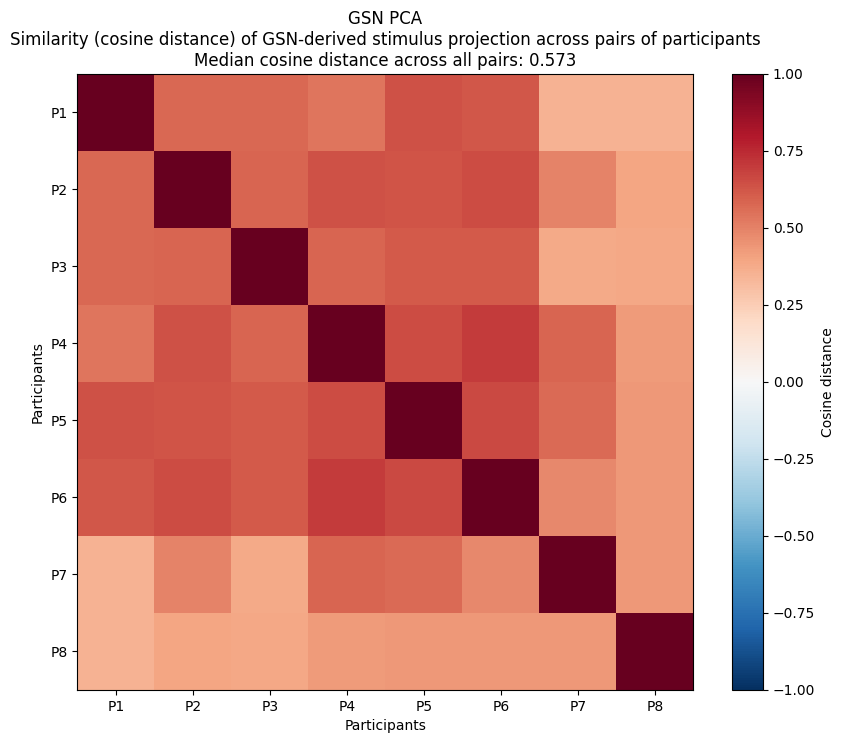

In [76]:
# Plot pairwise heatmap
plt.figure(figsize=(10, 8))
plt.imshow(GSN_cos_sim, cmap='RdBu_r', vmin=-1, vmax=1)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.xticks(ticks=np.arange(len(betas_list)), labels=[f'P{i+1}' for i in range(len(betas_list))])
plt.yticks(ticks=np.arange(len(betas_list)), labels=[f'P{i+1}' for i in range(len(betas_list))])
plt.colorbar(label='Cosine distance')
plt.title(f'GSN PCA\nSimilarity (cosine distance) of GSN-derived stimulus projection across pairs of participants\nMedian cosine distance across all pairs: {GSN_median_cos_sim:.3f}')
plt.show()

This heatmap shows that stimulus projections onto the first eigenvector of the GSN-derived signal covariance are highly correlated across participants, suggesting that the primary dimension driving voxel responses is shared across individuals. Next, we compare this to a naive approach: computing the covariance directly from trial-averaged data (bypassing GSN) and evaluating cross-participant consistency of the resulting projections.

# Standard PCA

In [77]:
PCA_proj_across_participants = []
for i, betas in enumerate(betas_list):
    print(f'Running naive PCA for participant {i+1}/{len(betas_list)}')

    # First, average the neural data over the trial dimension
    betas_trialavg = np.mean(betas, axis=2)  # Average across trials (3rd dimension) (vertices, images)

    # Demean the responses per voxel (technically not necessary because np.cov does this already, but for good practice)
    D = betas_trialavg - np.mean(betas_trialavg, axis=1).reshape(-1, 1)  # (vertices, images)

    # Compute covariance matrix from the trial-averaged data
    cov = np.cov(D)  # (voxels, voxels)

    # Obtain eigenvectors
    evals, evecs = np.linalg.eigh(cov)
    idx = np.argsort(np.abs(evals))[::-1]  # Sort eigenvalues in descending order
    evals = evals[idx]  # Sort eigenvalues
    evecs = evecs[:, idx]  # Sort eigenvectors accordingly 

    # The eigenvectors have arbitrary sign, so to make them comparable across participants, we flip the sign if the mean of the eigenvector is negative
    for j in range(evecs.shape[1]):
        if np.mean(evecs[:, j]) < 0:
            evecs[:, j] = -evecs[:, j]

    # Project data onto the first eigenvector
    proj = np.dot(D.T, evecs[:, :1]) # (images, 1)
    if i == 0:
        print(f'\nShape of stimulus projection onto the first eigenvector: {proj.shape}\n')
    PCA_proj_across_participants.append(proj)

Running naive PCA for participant 1/8

Shape of stimulus projection onto the first eigenvector: (515, 1)

Running naive PCA for participant 2/8
Running naive PCA for participant 3/8
Running naive PCA for participant 4/8
Running naive PCA for participant 5/8
Running naive PCA for participant 6/8
Running naive PCA for participant 7/8
Running naive PCA for participant 8/8


We have computed the stimulus projections onto the first eigenvector for all 8 participants using a covariance computed from trial-averaged data (a mix of signal and noise). As in the GSN case, can can now compare how similar those are across participants by computing the cosine distance among each pair of participants.

In [78]:
PCA_proj_across_participants = np.array(PCA_proj_across_participants)  # Convert to numpy array

# Get the projections into an array of shape (participants, images)
PCA_proj = PCA_proj_across_participants[:, :, 0]
# Compute pairwise cosine similarity
PCA_cos_sim = cosine_similarity(PCA_proj)  # Shape: (participants, participants)

# Compute the median cosine distance among the participant pairs
PCA_median_cos_sim = np.median(PCA_cos_sim[np.triu_indices(PCA_cos_sim.shape[0], k=1)])

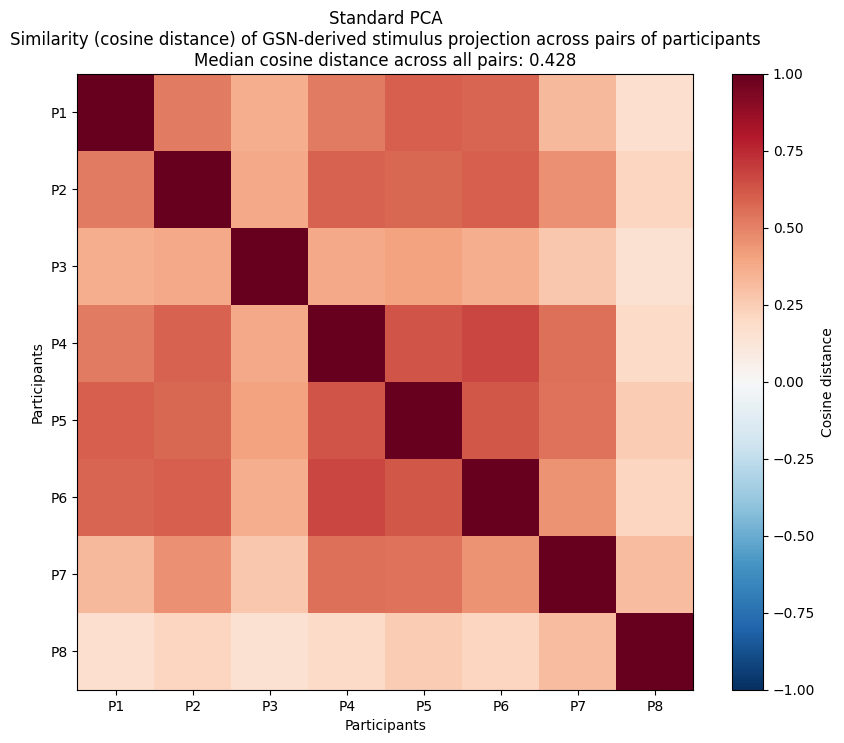

In [80]:
# Plot pairwise heatmap
plt.figure(figsize=(10, 8))
plt.imshow(PCA_cos_sim, cmap='RdBu_r', vmin=-1, vmax=1)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.xticks(ticks=np.arange(len(betas_list)), labels=[f'P{i+1}' for i in range(len(betas_list))])
plt.yticks(ticks=np.arange(len(betas_list)), labels=[f'P{i+1}' for i in range(len(betas_list))])
plt.colorbar(label='Cosine distance')
plt.title(f'Standard PCA\nSimilarity (cosine distance) of GSN-derived stimulus projection across pairs of participants\nMedian cosine distance across all pairs: {PCA_median_cos_sim:.3f}')
plt.show()

# Direct comparison between GSN PCA and standard PCA

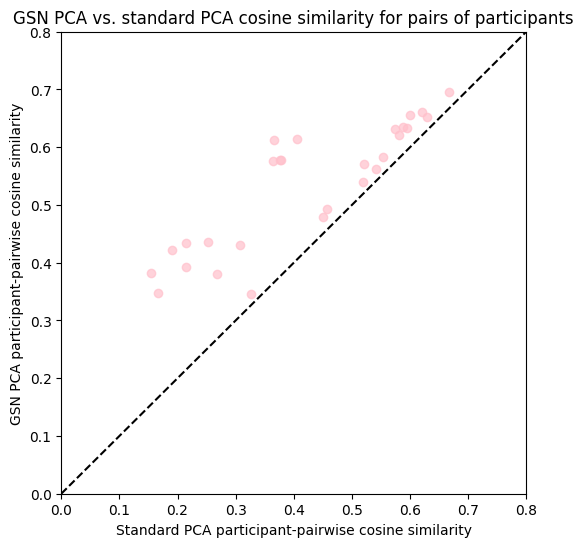

In [83]:
# We can show the participant-pairwise cosine distances on a scatter plot directly
plt.figure(figsize=(6,6))
plt.scatter(PCA_cos_sim[np.triu_indices(PCA_cos_sim.shape[0], k=1)],
            GSN_cos_sim[np.triu_indices(GSN_cos_sim.shape[0], k=1)],
           color='pink',alpha=0.7)
plt.xlabel('Standard PCA participant-pairwise cosine similarity')
plt.ylabel('GSN PCA participant-pairwise cosine similarity')
plt.title('GSN PCA vs. standard PCA cosine similarity for pairs of participants')
plt.xlim([0, 0.8])
plt.ylim([0, 0.8])
plt.plot([0, 0.8], [0, 0.8], 'k--')
plt.show()

The results show that the projections from GSN are substantially more consistent across participants than the standard PCA analysis. This implies that GSN is successfully reducing the influence of noise on principal components derived from the data, and that the principal components derived by GSN better reflect the underlying coding dimensions in the brain that are shared across humans.